# VGG16 을 이용한 학습

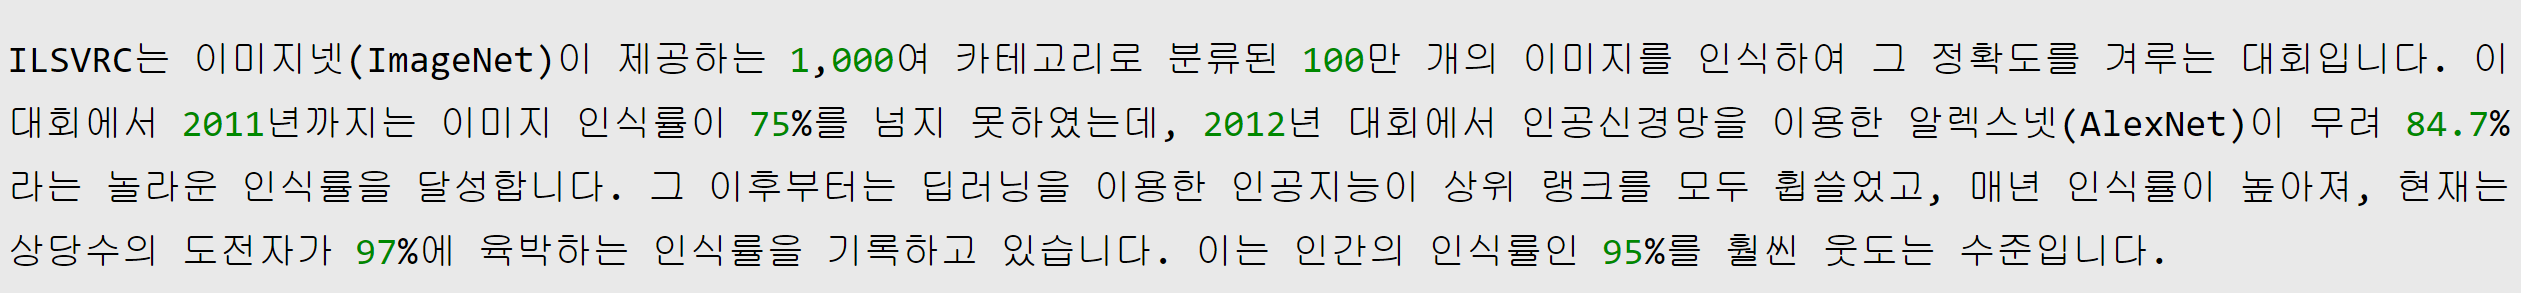

# 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [ ]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [ ]:
# 데이터 경로
data_path = '/content/drive/MyDrive/Colab Notebooks/프로젝트_데이터/'

In [ ]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [ ]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
589,v_TennisSwing_g25_c02.avi,TennisSwing
590,v_TennisSwing_g25_c03.avi,TennisSwing
591,v_TennisSwing_g25_c04.avi,TennisSwing
592,v_TennisSwing_g25_c05.avi,TennisSwing


In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [ ]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
589,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
590,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
591,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
592,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [ ]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard',
       'TennisSwing'], dtype=object)

In [ ]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [ ]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
589,v_TennisSwing_g25_c02.avi,TennisSwing,4
590,v_TennisSwing_g25_c03.avi,TennisSwing,4
591,v_TennisSwing_g25_c04.avi,TennisSwing,4
592,v_TennisSwing_g25_c05.avi,TennisSwing,4


In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [ ]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
386,v_ShavingBeard_g12_c03.avi,ShavingBeard,3
22,v_CricketShot_g11_c02.avi,CricketShot,0
524,v_TennisSwing_g14_c07.avi,TennisSwing,4
219,v_PlayingCello_g23_c03.avi,PlayingCello,1
337,v_Punch_g22_c07.avi,Punch,2
...,...,...,...
27,v_CricketShot_g11_c07.avi,CricketShot,0
380,v_ShavingBeard_g11_c01.avi,ShavingBeard,3
581,v_TennisSwing_g23_c06.avi,TennisSwing,4
207,v_PlayingCello_g21_c03.avi,PlayingCello,1


In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [ ]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [ ]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [ ]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [ ]:
# 비디오 프레임을 이미지로 변환한 데이터를 X_train에 저장
# 비디오 프레임 이미지의 종류를 y_train에 저장
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

#모델 생성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [ ]:
# VGG16 : VGG16 객체를 리턴
#include_top=True : 이미지넷 대회처럼 1000 가지 이미지로 분류 
#include_top=False : 이미지는 분류하지 않고  이미지의 특성을 추출하는 필터와 맥스풀링만 사용
# input_shape=(224, 224, 3) : 입력 이미지의 크기 224줄 224칸 3 컬러
vggnet = VGG16( include_top=False,input_shape=(224, 224, 3))

In [ ]:
# 이미지넷 대회에서 사용한 필터들의 값을 수정하지 않고 그대로 사용
vggnet.trainable=False

In [ ]:
vggnet.summary()

In [ ]:
#입력값을 읽어서 예측을 할 Sequential 객체 생성
model = Sequential()

In [ ]:
#vggnet 추가
model.add(vggnet)

In [ ]:
#선형 회귀를 하기 위해서 합성곱 연산을 수행한 결과를 1차원 배열로 변환
model.add(Flatten())

In [ ]:
#Dense : 선형 회귀를 수행할 객체
#Dense(출력데이터의 칸의수) : 출력 데이터 칸의 수는 256 이므로
#Dense(256)  
# activation="relu" :선형 회귀 후 relu 활성 함수 사용
#model.add(Dense(256, activation='relu')) :Dense 모델을 예측 할 수 있도록 model에 추가
model.add(Dense(256, activation='relu'))

In [ ]:
#전체 데이터 중 20%에 대해서만 기울기를 계산해서 수정
model.add(Dropout(0.8))

In [ ]:
#Dense : 선형 회귀를 수행할 객체
#Dense(출력데이터의 칸의수) : 출력 데이터 칸의 수는 3이므로
#Dense(3)

#Dense(3) : 선형 회귀를 할 객체를 생성  출력 칸수는 3
    
# activation="softmax" :선형 회귀 후 softmax 함수를 활성 함수를 이용해서 다중분루  
    
    
#model.add(Dense(3, activation="softmax")):Dense 모델을 예측 할 수 있도록 model에 추가
model.add(Dense(3, activation="softmax"))

In [ ]:
#생성된 모델 정보 출력
model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
#GradientDecnet를 이용해서 w1,w2,w3,w4를 찾는 방법을 설정함
#loss='categorical_crossentropy' : -(y * tf.log(hypothesis1)) 합 이 최소가 되는 w1,w2,w3,w4 를 찾음
#optimizer=Adam(lr=1e-4) : learning rate를 0.0001 로 설정
model.compile(
                  loss="categorical_crossentropy", 
                   optimizer=Adam(lr=1e-4),
                   metrics=["acc"]
              )

#이미지 증강

## GridSearchCV 사용해보기

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'rotation_range' : [30, 60, 90],
          # 'zoom_range' : [0.15, 0.3, 0.5],
          # 'width_shift_range' : [0.1, 0.2, 0.3],
          # 'height_shift_range' : [0.1, 0.2, 0.3],
          # 'brightness_range' : [0.7, 1.3],
          'shear_range' : [0.1, 0.15, 0.3],
          'horizontal_flip' : [True],
          'rescale' : [1 / 255],
          }

# train_datagen = ImageDataGenerator(params)

In [ ]:
gs = GridSearchCV(model, param_grid = params, cv = 5, n_jobs = 1, scoring='accuracy')

In [ ]:
gs.estimator

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

Kmodel = KerasClassifier(build_fn=model, verbose=1)
grid = GridSearchCV(estimator=Kmodel, param_grid=params, scoring='accuracy', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


INFO:tensorflow:Assets written to: ram://dccee2ff-73e4-4ec7-936d-022bab4af7a1/assets


In [ ]:
grid_result

In [ ]:
# # 이미지를 증강하는 ImageGenerator 객체 생성
# train_datagen = ImageDataGenerator(
# 	rotation_range=30, # 이미지 회전 각도
# 	zoom_range=0.15, # 이미지 확대 비율
# 	width_shift_range=0.2, # 이미지 가로 이동 비율
# 	height_shift_range=0.2, # 이미지 세로 이동 비율
# 	brightness_range = [0.7, 1.3], # Tuple or list of two floats,밝기 이동 값 선택 범위
# 	shear_range=0.15, # 이미지 기울기 비율
# 	horizontal_flip=True, # 이미지 좌우 반전
# 	vertical_flip = True, # 이미지 상하 반전
# 	rescale=1/255 # 이미지에 1/255 를 곱해줌
# 	)

In [ ]:
#0번째 이미지 조회
X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
# 이미지 학습
model.fit(
	# 32개의 이미지씩 증강해서 학습  
	train_datagen.flow(X_train, y_train, batch_size = 32),
    # 2번 반복해서 전체 이미지 학습 
	epochs = 2)

# 강사님 코드에서 밝기, 상하반전, zoom_range 변경
# Epoch 1/2
# 223/223 [==============================] - 137s 550ms/step - loss: 0.4794 - acc: 0.8062
# Epoch 2/2
# 223/223 [==============================] - 115s 514ms/step - loss: 0.1966 - acc: 0.9315
# # 이미지를 증강하는 ImageGenerator 객체 생성
# train_datagen = ImageDataGenerator(
# 	rotation_range=30, # 이미지 회전 각도
# 	zoom_range=0.3, # 이미지 확대 비율
# 	width_shift_range=0.2, # 이미지 가로 이동 비율
# 	height_shift_range=0.2, # 이미지 세로 이동 비율
# 	brightness_range = [0.7, 1.3], # Tuple or list of two floats,밝기 이동 값 선택 범위
# 	shear_range=0.15, # 이미지 기울기 비율
# 	horizontal_flip=True, # 이미지 좌우 반전
# 	vertical_flip = True, # 이미지 상하 반전
# 	rescale=1/255 # 이미지에 1/255 를 곱해줌
# 	)

# 강사님 코드에서 밝기, 상하반전 변경
# Epoch 1/2
# 223/223 [==============================] - 124s 526ms/step - loss: 0.4497 - acc: 0.8177
# Epoch 2/2
# 223/223 [==============================] - 116s 521ms/step - loss: 0.1641 - acc: 0.9479

Epoch 1/2
223/223 [==============================] - 124s 526ms/step - loss: 0.4497 - acc: 0.8177
Epoch 2/2
223/223 [==============================] - 116s 521ms/step - loss: 0.1641 - acc: 0.9479


In [ ]:
# 학습한 VGG16 모델 저장
#model.save(data_path + "vgg16_train.h5")